# Break repeating-key XOR
### It is officially on, now.
> This challenge isn't conceptually hard, but it involves actual error-prone coding. The other challenges in this set are there to bring you up to speed. This one is there to qualify you. If you can do this one, you're probably just fine up to Set 6.

There's a file here. It's been base64'd after being encrypted with repeating-key XOR.

Decrypt it.

Here's how:

1. Let KEYSIZE be the guessed length of the key; try values from 2 to (say) 40.
2. Write a function to compute the edit distance/Hamming distance between two strings. The Hamming distance is just the number of differing bits. The distance between:
```
this is a test
```
and
```
wokka wokka!!!
```
is 37. Make sure your code agrees before you proceed.
3. For each KEYSIZE, take the first KEYSIZE worth of bytes, and the second KEYSIZE worth of bytes, and find the edit distance between them. Normalize this result by dividing by KEYSIZE.
4. The KEYSIZE with the smallest normalized edit distance is probably the key. You could proceed perhaps with the smallest 2-3 KEYSIZE values. Or take 4 KEYSIZE blocks instead of 2 and average the distances.
5. Now that you probably know the KEYSIZE: break the ciphertext into blocks of KEYSIZE length.
6. Now transpose the blocks: make a block that is the first byte of every block, and a block that is the second byte of every block, and so on.
7. Solve each block as if it was single-character XOR. You already have code to do this.
8. For each block, the single-byte XOR key that produces the best looking histogram is the repeating-key XOR key byte for that block. Put them together and you have the key.

This code is going to turn out to be surprisingly useful later on. Breaking repeating-key XOR ("Vigenere") statistically is obviously an academic exercise, a "Crypto 101" thing. But more people "know how" to break it than can actually break it, and a similar technique breaks something much more important.

### No, that's not a mistake.
> We get more tech support questions for this challenge than any of the other ones. We promise, there aren't any blatant errors in this text. In particular: the "wokka wokka!!!" edit distance really is 37.

In [1]:
from cryptopals import *

In [2]:
def hamming_distance(b1, b2):
    '''Finds the bit-wise edit distance / Hamming distance between two byte arrays'''
    return sum(['{0:b}'.format(b).count('1') for b in fixed_xor(b1, b2)])

def hamming_distance_str(s1, s2):
    '''Finds the bit-wise edit distance / Hamming distance between two ascii-encoded strings'''
    return hamming_distance(s1.encode(), s2.encode())

def base64_to_bytes(s):
    '''Converts base64-encoded string to byte array'''
    return base64.b64decode(s)

In [3]:
t1 = 'this is a test'
t2 = 'wokka wokka!!!'

In [4]:
fixed_xor(t1.encode(), t2.encode())

b'\x03\x07\x02\x18AI\x04O\nK\x15DRU'

In [5]:
sum([sum(map(lambda c: c=='1', '{0:b}'.format(b))) for b in fixed_xor(t1.encode(), t2.encode())])

37

In [6]:
list(map(lambda c: c=='1', '{0:b}'.format(73)))

[True, False, False, True, False, False, True]

In [7]:
hamming_distance_str(t1, t2)

37

In [8]:
ct = ''
with open('../Data/6.txt') as f:
    for row in f:
        ct += row.strip()

In [9]:
b = base64_to_bytes(ct)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
def find_keysize_distances(bs, keysizes):
    '''Returns the average Hamming distance for a given keysize'''
    return [np.mean([hamming_distance(bs[i*keysize:(i+1)*keysize],
                                      bs[(i+1)*keysize:(i+2)*keysize]) // keysize
                     for i in range(len(bs)//keysize - 1)])
            for keysize in keysizes]

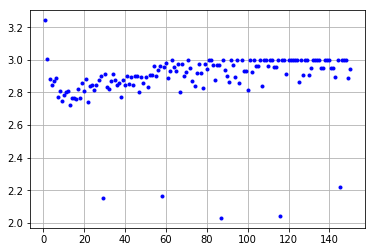

CPU times: user 455 ms, sys: 8.07 ms, total: 463 ms
Wall time: 491 ms


In [21]:
%%time
plt.plot(range(1,151), find_keysize_distances(b, range(1,151)), 'b.')
plt.grid()
plt.show()

In [22]:
def decrypt_vigenere_with_known_keysize(ciphertext, keysize):
    '''Returns the most likely key and plaintext message, given a bytearray ciphertext and known keysize'''
    keys, plaintexts = zip(*[decrypt_single_byte_xor(ciphertext[block::keysize]) for block in range(keysize)])
    return bytes(keys).decode(), bytes(sum(zip(*plaintexts), ())).decode()

In [23]:
def decrypt_vigenere(ciphertext, keysizes):
    '''Returns the most likely key and plaintext message, given a bytearray ciphertext and list of possible keysizes'''
    optimal_keysize = keysizes[np.argmin(find_keysize_distances(ciphertext, keysizes))]
    return decrypt_vigenere_with_known_keysize(ciphertext, optimal_keysize)

In [26]:
%%time 
k, pt = decrypt_vigenere(b, list(range(2,41)))
print('Key:', k)
print()
print('Plaintext:', pt)

Key: Terminator X: Bring the noise

Plaintext: I'm back and I'm ringin' the bell 
A rockin' on the mike while the fly girls yell 
In ecstasy in the back of me 
Well that's my DJ Deshay cuttin' all them Z's 
Hittin' hard and the girlies goin' crazy 
Vanilla's on the mike, man I'm not lazy. 

I'm lettin' my drug kick in 
It controls my mouth and I begin 
To just let it flow, let my concepts go 
My posse's to the side yellin', Go Vanilla Go! 

Smooth 'cause that's the way I will be 
And if you don't give a damn, then 
Why you starin' at me 
So get off 'cause I control the stage 
There's no dissin' allowed 
I'm in my own phase 
The girlies sa y they love me and that is ok 
And I can dance better than any kid n' play 

Stage 2 -- Yea the one ya' wanna listen to 
It's off my head so let the beat play through 
So I can funk it up and make it sound good 
1-2-3 Yo -- Knock on some wood 
For good luck, I like my rhymes atrocious 
Supercalafragilisticexpialidocious 
I'm an effect and that you can